In [1]:
## Import all the things

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd


import pycountry

import matplotlib.ticker as ticker

# from mpl_toolkits.basemap import Basemap

from scipy.stats import gaussian_kde


from IPython.display import display, Markdown, Latex, display_markdown


from shapely.geometry import Point

# import folium
# from folium.plugins import HeatMap, HeatMapWithTime, MarkerCluster
import os

import datetime

%matplotlib inline 

# This allows cells with long text values to wrap
pd.set_option('display.max_colwidth', -1)


pd.set_option('max_rows', 200)

In [2]:
# Load data for maps

# bounding box
bbox = gpd.read_file("../data_files/spatial-vector-lidar/global/ne_110m_graticules_all/ne_110m_wgs84_bounding_box.shp")
bbox_robinson = bbox.to_crs('+proj=robin')

# world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).to_crs(epsg=4326) #.to_crs('+proj=robin') # world map
world_robinson = world.to_crs('+proj=robin')


# Set up function to add row/column totals to dataframes
def add_totals(df):
    df['row total'] = df.sum(axis=1)
    df = df.append(df.sum(axis=0).rename("column total"))
    return df

# Define constants

report_date = pd.Timestamp(2018, 10, 31)
# report_date

report_year = report_date.strftime('%Y')
report_day = report_date.strftime('%d')
report_month = report_date.strftime('%B')


In [3]:
def get_country_name(alpha2_code):
    
    '''
    Takes a two character country code and
    returns the full name of the country.
    '''

    try:
        return pycountry.countries.get(alpha_2=alpha2_code).name
#         return pycountry.countries.
    except KeyError:
        if alpha2_code == "W3":
            return "online"
        else:
            return "unknown"
        
        
def get_country_code3(alpha2_code):
    
    '''
    Takes a two character country code and
    returns the full name of the country.
    '''

    try:
        return pycountry.countries.get(alpha_2=alpha2_code).alpha_3
#         return pycountry.countries.
    except KeyError:
        if alpha2_code == "W3":
            return "online"
        else:
            return "unknown"
        
        
# Function to create dataframes of counts and percentages by category (previous experience, expertise)
# when option is check many 
def get_value_counts_many(df, col_name, value_list):
    """
    Takes the parameters:
    * dataframe
    * the column in the df you want to group and count by
    * The list of characteristics (to ensure sort order)

    Returns a two column dataframe that has the grouped column and the count by that column

    
    """    
    
    df_counts = pd.DataFrame(columns=[col_name, 'Count'])
    
    for v in value_list:
#         count = df[col_name].apply(lambda x:x.count(v)).sum()
        count = df[col_name].str.count(v).sum()
        df_counts.loc[len(df_counts)] = [v, count]
        
    return df_counts   



    




In [4]:
# Load csv into df

all_events = pd.read_csv("../data_files/all_workshops.csv", keep_default_na=False, na_values=[''])
# all_events

# The Carpentries: Programmatic Assessment Report


**January 1, 2012 to {{ report_month }} {{ report_day }}, {{ report_year }}**

**Authors: Maneesha Sane, Erin Becker**

## What is The Carpentries?
Software Carpentry (SWC) and Data Carpentry (DC) are two lesson programs of The Carpentries (a fiscally sponsored project of Community Initiatives). We teach essential computing and data skills. We exist because the skills needed to do computational, data-intensive research are not part of basic research training in most disciplines.

## About Software Carpentry
Software Carpentry enables researchers to create purpose-built tools, whether it be a Unix shell script to automate repetitive tasks, or software code in programming languages such as Python or R. These enable researchers to build programs that can be read, re-used, and validated, greatly enhancing the sharing and reproducibility of their research.

## About Data Carpentry
Data Carpentry learners are taught to work with data more effectively. Workshops focus on the data lifecycle, covering data organization, cleaning and management through to data analysis and visualization. Lessons are domain-specific, with  curricula for working with ecological data, genomic sequencing data, social sciences survey data, and geospatial data.

## About Library Carpentry
Library Carpentry develops lessons and teaches workshops for and with people working in library- and information-related roles. Our goal is to create an on-ramp to empower this community to use software and data in their own work as well as be advocates for and train others in efficient, effective and reproducible data and software practices.  Library Carpentry data is not included in this report as it joined The Carpentries as a lesson program on November 1, 2018.  Future Carpentries programmatic assessment reports will include Library Carpentry data. 


## What The Carpentries offers

* A suite of open source, collaboratively-built, community-developed lessons
* Workshops based on a learn-by-doing, ‘code with me’ approach
* A supportive learning culture
* Instructor training, mentoring and support
* Active global community which subscribes to an inclusive code of conduct
* Evidence-based, proven pedagogical training methods
* Ongoing development opportunities 
* Open discussions

The Carpentries began systematically recording data for our workshops in 2012. We use this data to investigate how The Carpentries has grown over the years including number and geographic reach of our workshops, and learners at these workshops. We also look at our Instructor Training program, including number and geographic reach of instructor training events, number of trainees and their completion rates, and onboarding of new Instructor Trainers.

Data are collected by a team of Workshop Administrators. In Africa, Australia, Canada, New Zealand, and the United Kingdom, Workshop Administrators are affiliated with our member institutions and provide in-kind staff time. A full-time Carpentries staff member is the Workshop Administrator for the rest the world.



# Part 1: Workshops

Carpentries workshops generally comprise two full days of face-to-face instruction, based on materials specific to their lesson programs.

Workshops are taught by volunteer trained and certified Instructors. Certified Instructors comprise people who have completed our instructor training course. Carpentries lessons are all open source, and are hosted on GitHub.

The full data set can be found in the Programmatic Assessment folder of The Carpentries Assessment repository on GitHub (https://github.com/carpentries/assessment/)


In [5]:
#####
# Replace country codes with full country name
# Set distinct workshop type (SWC, DC, LC, TTT)
# Set NaN attendance data to zero
# Convert workshop dates to date format
# Get just the regular workshops (not TTT events, not onboarding events, etc)
##### 

all_events.rename(columns={"country": "country2",}, inplace=True)

# Apply the function to get the full country name
all_events['country'] = all_events['country2'].apply(get_country_name)
all_events['country3'] = all_events['country2'].apply(get_country_code3)

# Clean up the tag names
# Create a new column for "workshop_type"; populate it SWC, DC, LC, or TTT
# Remove the old "tag_name" column
all_events.loc[all_events['tag_name'].str.contains("SWC"), "workshop_type"] = "SWC"
all_events.loc[all_events['tag_name'].str.contains("DC"), "workshop_type"] = "DC"
all_events.loc[all_events['tag_name'].str.contains("LC"), "workshop_type"] = "LC"
all_events.loc[all_events['tag_name'].str.contains("TTT"), "workshop_type"] = "TTT"
all_events = all_events.drop('tag_name', axis=1)

# Clean up attendance value - this is inconsistently stored as NaN or 0
# All zero values should be NaN
all_events['attendance'] =  all_events['attendance'].replace(0.0, np.nan)

# Date data type
all_events['start_date'] = pd.to_datetime(all_events['start_date'])

# Remove events after report date
all_events = all_events[all_events['start_date'] < report_date]


# Remove instructor training events; these will be analyzed separately.
# Limit to non TTT workshops
workshops = all_events[all_events['workshop_type'] != "TTT"]

# Remove online events like maintainer onboarding
workshops = workshops.drop(workshops[workshops.country == "online"].index)

In [6]:
# Count of workshops by Carpentry and by year. This year's data is actual, not projected.

workshops_by_carpentry_year = workshops.groupby([workshops['start_date'].dt.year, 'workshop_type'])['slug'].count().unstack()

# To calculate projections for current year, take number of workshops at same point in last year

# Get the year of the max date in our data set
current_year = max(workshops['start_date'].dt.year)

# Get one year ago based on that
last_year = current_year - 1

# Get the actual date of the latest workshop in our data set
latest_workshop_date = max(workshops['start_date'])

# Get the comparison date one year ago
last_year_comparision_date = max(workshops['start_date']) - datetime.timedelta(days=365)

# January 1 of last year
# last_year_first_day = datetime.date(last_year, 1, 1)
last_year_first_day = pd.Timestamp(last_year, 1, 1)

# Count how many workshops happened between Jan 1 of last year and the comparison date one year ago
last_year_workshops_to_comp_date = workshops[(workshops.start_date >= last_year_first_day) & (workshops.start_date <= last_year_comparision_date)]

# Count how many workshops happened total last year
count_last_year_workshops = len(workshops[workshops['start_date'].dt.year == last_year])

# Count YTD workshops this year
count_this_year_workshops = len(workshops[workshops['start_date'].dt.year == current_year])

# Last year's workshops by Carpentry by year through the comparison date
last_year_to_comp_date_by_carpentry = last_year_workshops_to_comp_date.groupby([last_year_workshops_to_comp_date['start_date'].dt.year, 'workshop_type'])['slug'].count().unstack()

# Last year's workshops by Carpentry by year total
last_year_total_by_carpentry = workshops_by_carpentry_year.loc[[last_year]]

# This year's workshops by Carpentry by year to date
this_year_to_date_by_carpentry = workshops_by_carpentry_year.loc[[current_year]]

# Proportion of workshops by Carpentry by year that had occured by the comparison date
proportion = last_year_to_comp_date_by_carpentry/last_year_total_by_carpentry

# Rename the rows so we can run calculations on them
this_year_to_date_by_carpentry.rename({current_year:1}, inplace=True)
proportion.rename({last_year:1}, inplace=True)

# Assuming current year will progress at same proportionate rate
# calculate the projected number of workshops for the current year
current_year_projected = this_year_to_date_by_carpentry.iloc[[0]]/proportion.iloc[[0]]

# Rename the row for the current year projections
current_year_projected.rename({1:current_year}, inplace=True)

# In the workshops by carpentry year dataframe, replace the actual current year data
# with projected current year data
workshops_by_carpentry_year.loc[[current_year]] = current_year_projected.loc[[current_year]]

# Replace the NaNs with 0 and convert floats to ints
workshops_by_carpentry_year.fillna(0, inplace=True)
workshops_by_carpentry_year = workshops_by_carpentry_year.round(0)
workshops_by_carpentry_year = workshops_by_carpentry_year.astype(int)

workshops_by_carpentry_year.index.name = 'Year'
workshops_by_carpentry_year.columns.name = "Workshop Type"

current_year_workshops = dict((workshops_by_carpentry_year.loc[current_year]))


## Figure 1: Workshops by Carpentry lesson program by Year

This bar chart shows the number of Data Carpentry (DC) and Software Carpentry (SWC) workshops each year. Data for 2018 is a projection calculated by looking at the number of workshops run in the same time period in 2017.  

In {{ current_year }} we expect to run {{ current_year_workshops['DC'] }} Data Carpentry and {{ current_year_workshops['SWC'] }} Software Carpentry workshops.

Source data can be found in Table 1 in the Appendix.

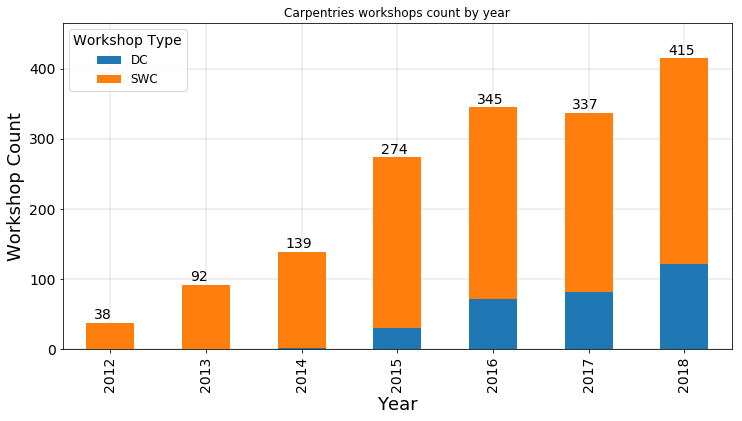

In [7]:
fig = plt.figure(figsize=(12, 6)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes

width = .5 # Set width of bar
title = "Carpentries workshops count by year"

# Set axes labels and legend
ax.set_xlabel("Year")
ax.set_ylabel("Workshop Count")
# ax.legend(title="Workshop Type", fontsize=12)

ax.title.set_size(18)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)

# Plot chart
workshops_by_carpentry_year.plot(y = ["DC", "SWC"], kind='bar', ax=ax, width=width,  title=title, stacked=True,)

leg = ax.legend(fontsize=12)
leg.set_title(title="Workshop Type", prop={'size':14,})


# Customize the gridlines
ax.grid(linestyle='-', linewidth='0.25', color='gray')

# Create a new dataframe that has just the total number of workshops by year
totals = workshops_by_carpentry_year['DC'] + workshops_by_carpentry_year['SWC']
years = list(totals.index)


# Figure out what the xmarks values are (xtick values; they are not year like you'd think)
# Add them to an empty list
# The list will be double what's expected as it goes through all the stacked values
xmarks = []
for p in ax.patches:
#     print("X: ", p.get_x())
#     print("Y: ", p.get_height())
    xmarks.append(p.get_x())


# Make an empty list to be populated with a tuple for each stack
# Go through the length of the totals series
# Add to the empty list a tuple: (position in totals df, position in xmarks list)
t = []

for y in range(len(totals)):
    t.append((list(totals)[y], xmarks[y]))


# Annotate the stacked bar chart with 
# (annotation text, position of text)
for p in t:
    ax.annotate(str(p[0]), (p[1] + .08, p[0] + 5), fontsize=14)

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)    

ax.set_ylim(0,max(totals) + 50)

    
# Display the plot   
plt.show()


# See
# https://stackoverflow.com/questions/40783669/stacked-bar-plot-by-group-count-on-pandas-python


In [8]:
# Actual data for workshops by country and year through 2018
# Projections for 2018 are calculated below

workshops_by_country_year = workshops.groupby(['country', workshops['start_date'].dt.year])['slug'].count().unstack()
workshops_by_country_year = workshops_by_country_year.fillna(0)

workshops_by_country_year.columns.names = ['Year']
workshops_by_country_year = workshops_by_country_year.astype(int)


# # Last year's workshops by country by year through the comparison date
# Take *all* of last year's workshop by the com date and group them by country
last_year_to_comp_date_by_country = last_year_workshops_to_comp_date.groupby(['country'])['slug'].count().to_frame() #.unstack()
# # current_year_projected.rename({1:current_year}, inplace=True)
last_year_to_comp_date_by_country.rename(columns={'slug':last_year}, inplace=True)

# Last year's workshops by Country by year total
# Get just the last_year column from the workshops_by_country_year df
last_year_total_by_country = workshops_by_country_year[[last_year]]

# This year's workshops by Country by year total
# Get just the current_year column from the workshops_by_country_year df
current_year_to_date_by_country = workshops_by_country_year[[current_year]]

# Proportion of workshops by Carpentry by year that had occurred by the comparison date
proportion = last_year_to_comp_date_by_country/last_year_total_by_country
projected_current_year = current_year_to_date_by_country[current_year]/proportion[last_year]
projected_current_year = projected_current_year.to_frame()
# display(projected_current_year)

# Add a column to the projected data that includes this year's actual data

projected_current_year[current_year] = workshops_by_country_year[current_year]

# Get the maximum of the two columns
# This is because when a country has just one workshop, the projection calculation makes the 
# total for the current year look like zero
workshops_by_country_year[current_year] = projected_current_year[[0, current_year]].max(axis=1)
workshops_by_country_year.fillna(0, inplace=True)
workshops_by_country_year = workshops_by_country_year.round(0)
workshops_by_country_year = workshops_by_country_year.astype(int)

workshops_by_country_year.index.name = 'Country'
workshops_by_country_year.columns.name = "Year"

# display(workshops_by_country_year)


In [9]:
# This adjusts for Ethiopia and South Africa
# both countries experiencing rapid recent growth, so the 
# projections done by proportion to last year are not accurate.
# For these countries, data for 9 months of 2018 is applied to
# the full year, rather than comparing this year to last year.

# This should NOT be automatically run when running this report again
# Specific adjustments may need to be made again

adjusted = workshops[workshops['country'].isin(['Ethiopia', 'South Africa'])].groupby(['country', workshops['start_date'].dt.year])['slug'].count().unstack()
adjusted[2018] = adjusted[2018]/10*12

adjusted.fillna(0, inplace=True)
adjusted = adjusted.round(0)
adjusted = adjusted.astype(int)

workshops_by_country_year[2018].loc[['South Africa']] = adjusted[2018].loc[['South Africa']]
workshops_by_country_year[2018].loc[['Ethiopia']] = adjusted[2018].loc[['Ethiopia']]


In [10]:
workshops_by_country_year_top = workshops_by_country_year[workshops_by_country_year.sum(axis=1) >= 10]

# Figure 2: Geographic Reach

Each dot on the map below represents one workshop since 2012.  Source data can be found in Table 2 in the Appendix.



In [11]:
workshops_with_location = workshops[workshops.latitude.notnull()]
workshops_with_location = workshops_with_location[workshops_with_location.longitude.notnull()]


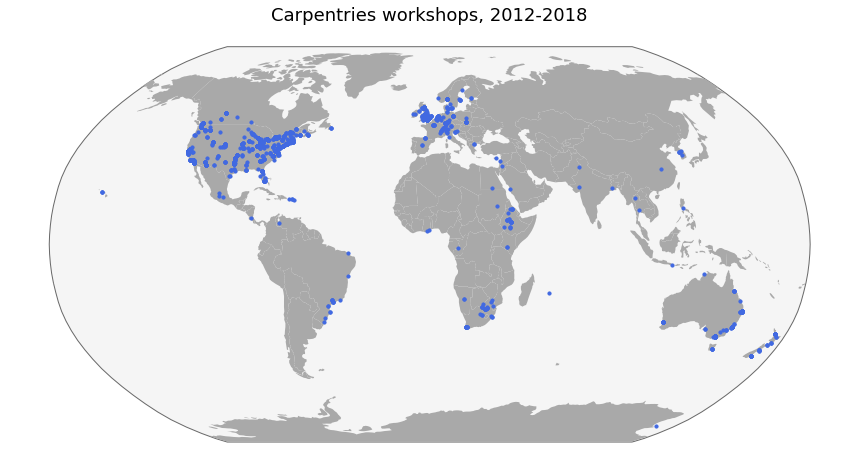

In [12]:
# For more info see 
# https://www.earthdatascience.org/courses/earth-analytics-python/spatial-data-vector-shapefiles/intro-to-coordinate-reference-systems-python/
# https://github.com/geopandas/geopandas/issues/245

# Make simple df with just the latlon columns
latlon = workshops_with_location[['longitude', 'latitude']]

# world map with latlong projections
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).to_crs(epsg=4326) #.to_crs('+proj=robin') # world map

# Turn latlon into list of shapely points
q  = [Point(xy) for xy in latlon.values]

# Create geodataframe using these points
q = gpd.GeoDataFrame(q, columns = ['geometry'])

# q.head()
# This is a "naive" object; need to explicitly set the crs to 4326 (latlon)
q.crs = {'init': 'epsg:4326', 'no_defs': True}

# Now translate both latlons to robinson projection - a bit "rounder"
# world = world.to_crs('+proj=robin')
q = q.to_crs('+proj=robin')


fig, ax = plt.subplots(figsize=(15, 8))

# Not sure what alpha means
bbox_robinson.plot(ax=ax, alpha=1, color='whitesmoke', edgecolor='dimgray')


world_robinson.plot(color='darkgrey', ax=ax,)

q.plot(ax=ax, color='royalblue', marker='o', markersize=10)

# ax.axis('off')

# facecolor will not work if ax.axis is off
# ax.patch.set_facecolor('whitesmoke')
# # Drop x & y axis ticks
plt.xticks([], [])
plt.yticks([], [])

ax.set_title("Carpentries workshops, 2012-2018")
ax.title.set_size(18)

# Make the axes invisible by making them the same color as the background
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')

plt.show()

## Figure 3: Countries hosting 10 or more workshops

This bar chart looks only at countries that have hosted 10 or more workshops since 2012. 
For each country, the number of workshops run each year is plotted. Data for {{ current_year }} is a 
projection. For most countries, this projection is based on the number of workshops run in the same time period in {{ last_year }}. For workshops in countries with a shorter history with The Carpentries (Ethiopia and South Africa), this projection is based on the average number of workshops per month in {{ current_year }}.

Source data can be found in Table 2 in the Appendix.

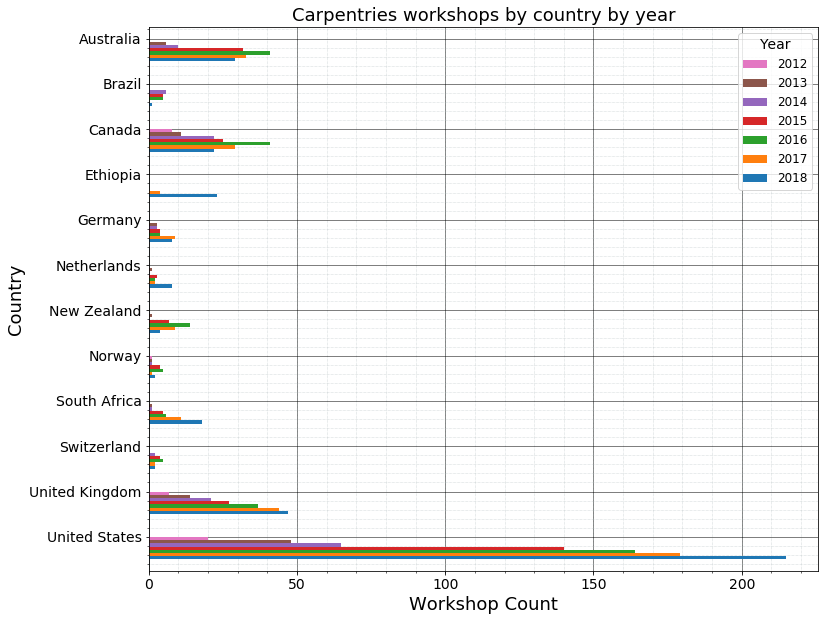

In [13]:
# Draw bar chart showing most active countries and workshops by year

fig = plt.figure(figsize=(12, 10)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes

title = "Carpentries workshops by country by year"
workshops_by_country_year_top[::-1].plot(y = list(workshops_by_country_year_top)[::-1], kind='barh', ax=ax, position=1, title=title)


# Set axes labels and legend
ax.set_xlabel("Workshop Count")
ax.set_ylabel("Country")
handles, labels = ax.get_legend_handles_labels()

leg = ax.legend(handles[::-1], labels[::-1], title="Year", fontsize=12,)
# leg = ax.legend(fontsize=12)
leg.set_title(title="Year", prop={'size':14,})
ax.title.set_size(18)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)

# Customize the gridlines
ax.grid(linestyle='-', linewidth='0.25', color='gray')

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

# Turn on the minor TICKS, which are required for the minor GRID
ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
# Customize the minor grid
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='#AAB7B8')

ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))

# https://www.oreilly.com/library/view/matplotlib-plotting-cookbook/9781849513265/ch03s11.html


plt.show()


# Part 2: Learners

In [14]:
workshops_current_year = workshops[workshops['start_date'].dt.year == current_year].copy()
workshops_current_year.attendance.fillna(0, inplace=True)
current_year_no_attendance = workshops_current_year[workshops_current_year.attendance ==0].copy()
percent_missing_attendance =  len(current_year_no_attendance)/len(workshops_current_year) * 100
percent_missing_attendance = int(percent_missing_attendance)

# print(percent_missing_attendance)

## Figure 4: Workshop Attendance

This bar chart represents the total number of Software Carpentry (SWC) and Data Carpentry (DC) learners each year.  Numbers for {{ current_year }} represent projected data.  However, approximately {{ percent_missing_attendance }}% of {{ current_year }} workshops have unreported attendance. Source data can be found in Table X in the Appendix. The Carpentries staff and workshop administrators are working to improve our data collection and reporting measures to have more complete and accurate attendance figures.

Source data can be found in Table 3 in the Appendix.

In [15]:
# Learners by year


# Actual data for learners by year through 2018
# Projections for 2018 are calculated below

learners_by_year = workshops.groupby([workshops['start_date'].dt.year, 'workshop_type'])['attendance'].sum().unstack()
learners_by_year = learners_by_year.fillna(0)
learners_by_year = learners_by_year.astype(int)


# Last year's attendance by year through the comparison date
# # Take *all* of last year's workshop by the com date and group them by Carpentry type
last_year_to_comp_date_attendance = last_year_workshops_to_comp_date.groupby([workshops['start_date'].dt.year, 'workshop_type'])['attendance'].sum().unstack()
# # # current_year_projected.rename({1:current_year}, inplace=True)
# last_year_to_comp_date_by_country.rename(columns={'slug':last_year}, inplace=True)

# Last year's workshops attendance by year total
# # Get just the last_year column from the workshops_by_country_year df
learners_last_year = learners_by_year.loc[[last_year]]

# Rename the rows so we can run calculations on them
learners_by_year.rename({current_year:1}, inplace=True)

x = last_year_to_comp_date_attendance/learners_last_year


x.rename({last_year:1}, inplace=True)

# learners_by_year.loc[[2018]]/x.loc[[2017]]
# display(x.loc[[2017]])
# display(learners_by_year.loc[[2018]])
# learners_by_year.loc[[2018]]/x.loc[[2017]]
learners_by_year.loc[[1]] = learners_by_year.loc[[1]]/x
learners_by_year.rename({1:current_year}, inplace=True)
learners_by_year = learners_by_year.round(0)
learners_by_year = learners_by_year.astype(int)


learners_by_year.index.name = 'Year'
learners_by_year.columns.name = "Workshop Type"


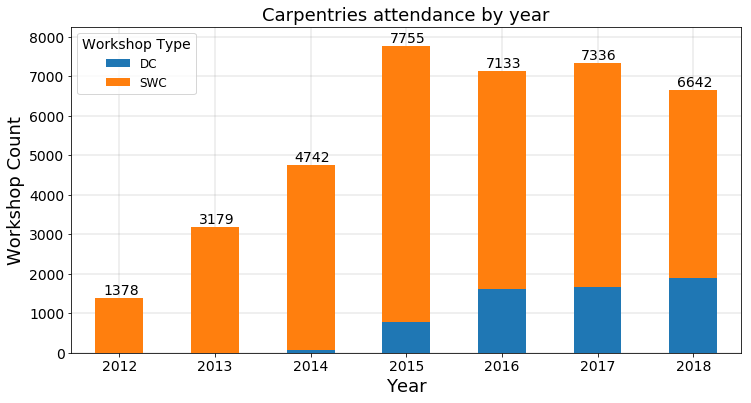

In [16]:
fig = plt.figure(figsize=(12, 6)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes

width = .5 # Set width of bar
title = "Carpentries attendance by year"

# Plot chart
# Having position=1 as an argument will make the bars not be centered on the x ticks
learners_by_year.plot(y = ["DC", "SWC"], kind='bar', ax=ax, width=width, title=title, stacked=True,)

# Set axes labels and legend
ax.set_xlabel("Year")
ax.set_ylabel("Workshop Count")
# ax.legend(title="Workshop Type", fontsize=12)
leg = ax.legend(fontsize=12)
leg.set_title(title="Workshop Type", prop={'size':14,})
ax.title.set_size(18)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)


# Customize the gridlines
ax.grid(linestyle='-', linewidth='0.25', color='gray')

# Create a new dataframe that has just the total number of workshops by year
totals = learners_by_year['DC'] + learners_by_year['SWC']
years = list(totals.index)


# Figure out what the xmarks values are (xtick values; they are not year like you'd think)
# Add them to an empty list
# The list will be double what's expected as it goes through all the stacked values
xmarks = []
for p in ax.patches:
#     print("X: ", p.get_x())
#     print("Y: ", p.get_height())
    xmarks.append(p.get_x())


# Make an empty list to be populated with a tuple for each stack
# Go through the length of the totals series
# Add to the empty list a tuple: (position in totals df, position in xmarks list)
t = []

for y in range(len(totals)):
    t.append((list(totals)[y], xmarks[y]))


# Annotate the stacked bar chart with 
# (annotation text, position of text)
for p in t:
    ax.annotate(str(p[0]), (p[1] + .08, p[0] + 100), fontsize=14)

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)    

ax.set_ylim(0,max(totals) + 500)

    
# Display the plot   
plt.show()


# See
# https://stackoverflow.com/questions/40783669/stacked-bar-plot-by-group-count-on-pandas-python


# Part 3: Instructor Training

## Overview

Over the last hundred years, researchers have discovered an enormous amount about how people learn and how best to teach them. Unfortunately, much of that knowledge has not yet been translated into common classroom practice, especially at the university level. To this goal, we offer an Instructor Training program.

This two-day class has the following overall goals:

* Introduce trainees to evidence-based best-practices of teaching.
* Teach how to create a positive environment for learners at Carpentries workshops.
* Provide opportunities for trainees to practice and build their teaching skills.
* Help trainees become integrated into the Carpentries community.
* Prepare trainees to use these teaching skills in teaching Carpentries workshops.

Because we have only two days, some things are beyond the scope of this class. We do not teach:

* How to program in R or Python, use git, or any of the other topics taught in Carpentries workshops.
* How to create lessons from scratch (although trainees will have a good start on the principles behind that sort of work if inspired to learn more).

This training is based on our constantly revised and updated curriculum (https://carpentries.github.io/instructor-training/ ).

After completing the two day training program and several checkout exercises, trainees are awarded a badge and are considered certified Carpentries instructors, qualified to teach any of our workshops.



In [17]:
all_applications = pd.read_csv("../data_files/amy_applications_20181023.csv", keep_default_na=False, na_values=[''])

## Figure 5: Instructor Training Applications by Previous Experience in Teaching

Source data can be found in Table 4 of the Appendix.

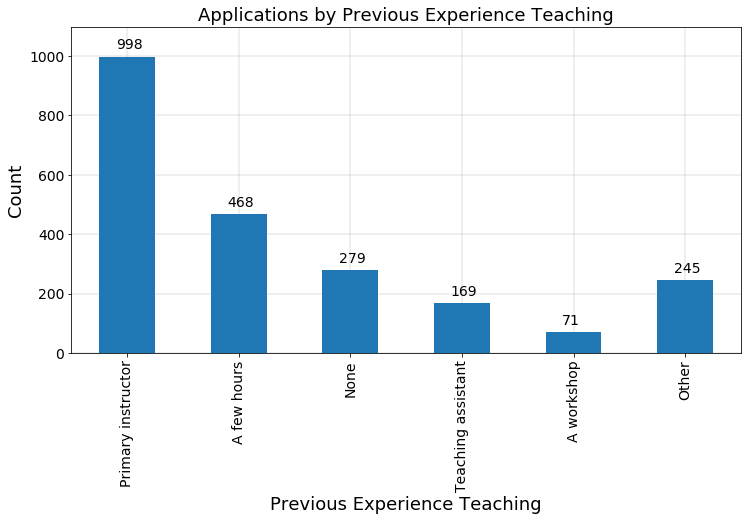

In [18]:
apps_by_prev_experience = all_applications['Previous Experience in Teaching'].value_counts().to_frame()
apps_by_prev_experience.rename(columns={'Previous Experience in Teaching':"Count", True:"online"}, inplace=True)
apps_by_prev_experience.index.name = 'Previous Experience'
apps_by_prev_experience.rename(index={'Primary instructor for a full course':'Primary instructor'},inplace=True)
apps_by_prev_experience.rename(index={'Teaching assistant for a full course':'Teaching assistant'},inplace=True)


apps_by_prev_experience.rename(index={'A workshop (full day or longer)':'A workshop'},inplace=True)

without_other = apps_by_prev_experience.drop("Other", axis=0).sort_values('Count', ascending=False)
just_other = apps_by_prev_experience.loc[['Other']]

apps_by_prev_experience = pd.concat([without_other, just_other])

fig = plt.figure(figsize=(12, 6)) # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
width = .5 # Set width of bar

title = "Applications by Previous Experience Teaching"
apps_by_prev_experience.plot(kind='bar', ax=ax, title=title, legend=False, grid=True,)

# # Set axes labels and legend
ax.set_xlabel("Previous Experience Teaching")
ax.set_ylabel("Count")


ax.title.set_size(18)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14, rotation=0)


ax.grid(linestyle='-', linewidth='0.25', color='gray')

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)   

for i, label in enumerate(list(apps_by_prev_experience.index)):
    count = apps_by_prev_experience.loc[label]['Count']
    ax.annotate(str(count), (i-.1, count + 25), fontsize=14)

ax.set_ylim(0, max(apps_by_prev_experience['Count']) + 100)   
    
plt.show()


## Figure 6: Instructor Training Applications by Previous Training in Teaching

Source data can be found in Table 5 of the Appendix.

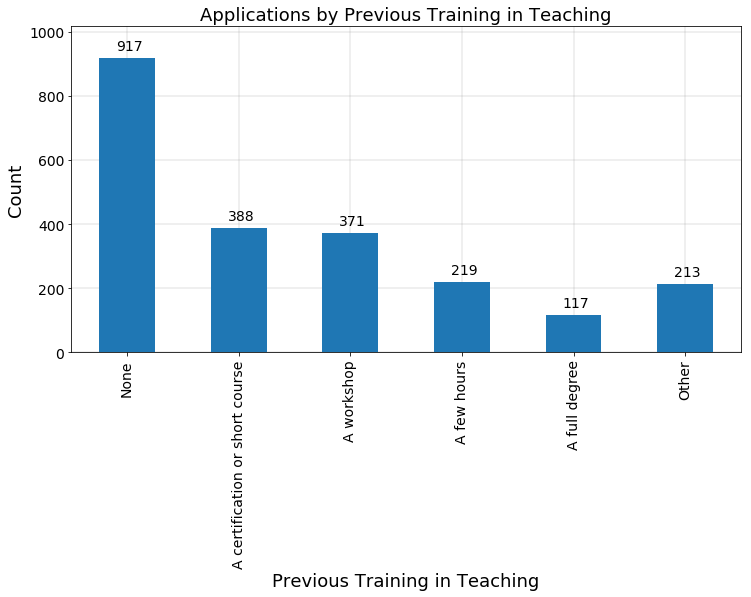

In [19]:
apps_by_prev_training = all_applications['Previous Training in Teaching'].value_counts().to_frame()
apps_by_prev_training.rename(columns={'Previous Training in Teaching':"Count", True:"online"}, inplace=True)

apps_by_prev_training.index.name = 'Previous Training'

fig = plt.figure(figsize=(12, 6)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
width = .5 # Set width of bar

without_other = apps_by_prev_training.drop("Other", axis=0).sort_values('Count', ascending=False)
just_other = apps_by_prev_training.loc[['Other']]

apps_by_prev_training = pd.concat([without_other, just_other])

title = "Applications by Previous Training in Teaching"
apps_by_prev_training.plot(kind='bar', ax=ax, title=title, legend=False, grid=True,)

# # Set axes labels and legend
ax.set_xlabel("Previous Training in Teaching")
ax.set_ylabel("Count")

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)   

ax.title.set_size(18)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
plt.xticks(fontsize=14, rotation=90)

plt.yticks(fontsize=14, rotation=0)

ax.grid(linestyle='-', linewidth='0.25', color='gray')


for i, label in enumerate(list(apps_by_prev_training.index)):
    count = apps_by_prev_training.loc[label]['Count']
    ax.annotate(str(count), (i - 0.1, count + 25), fontsize=14)

ax.set_ylim(0, max(apps_by_prev_training['Count']) + 100)   
    
plt.show()

## Figure 7: Instructor Training Applications by Areas of Expertise

Applicants can identify more than one area of expertise. Source data can be found in Table 6 of the Appendix.

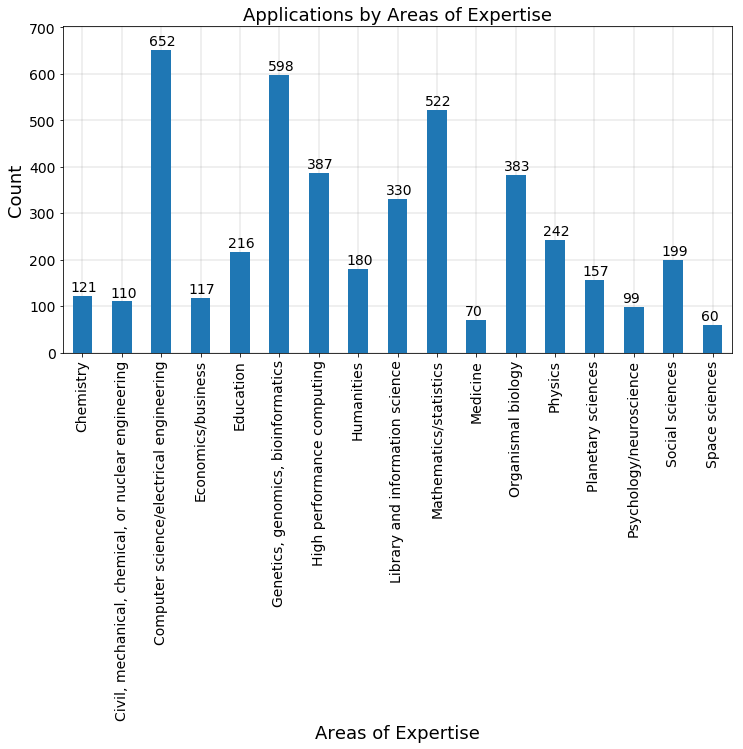

In [20]:
expertise_areas = ["Chemistry", "Civil, mechanical, chemical, or nuclear engineering", 
                   "Computer science/electrical engineering", "Economics/business", "Education", 
                   "Genetics, genomics, bioinformatics", "High performance computing", "Humanities",
                   "Library and information science", "Mathematics/statistics", "Medicine", 
                   "Organismal biology", "Physics", 
                   "Planetary sciences", 
                   "Psychology/neuroscience", "Social sciences", "Space sciences",]


apps_by_expertise_areas = get_value_counts_many(all_applications, "Expertise areas", expertise_areas)
apps_by_expertise_areas.set_index('Expertise areas', inplace=True)
apps_by_expertise_areas['Count'] = apps_by_expertise_areas['Count'].astype(int)

fig = plt.figure(figsize=(12, 6)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
width = .5 # Set width of bar


title = "Applications by Areas of Expertise"
apps_by_expertise_areas.plot(kind='bar', ax=ax, title=title, legend=False, grid=True,)

# # Set axes labels and legend
ax.set_xlabel("Areas of Expertise")
ax.set_ylabel("Count")

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)   

ax.title.set_size(18)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
plt.xticks(fontsize=14,)
plt.yticks(fontsize=14, rotation=0)

ax.grid(linestyle='-', linewidth='0.25', color='gray')


for i, label in enumerate(list(apps_by_expertise_areas.index)):
    count = apps_by_expertise_areas.loc[label]['Count']
    ax.annotate(str(count), (i- 0.3, count + 10), fontsize=14)

ax.set_ylim(0, max(apps_by_expertise_areas['Count']) + 50)   
    
plt.show()

## Figure 8: Instructor Training Applications by Occupation

Source data can be found in Table 7 of the Appendix.

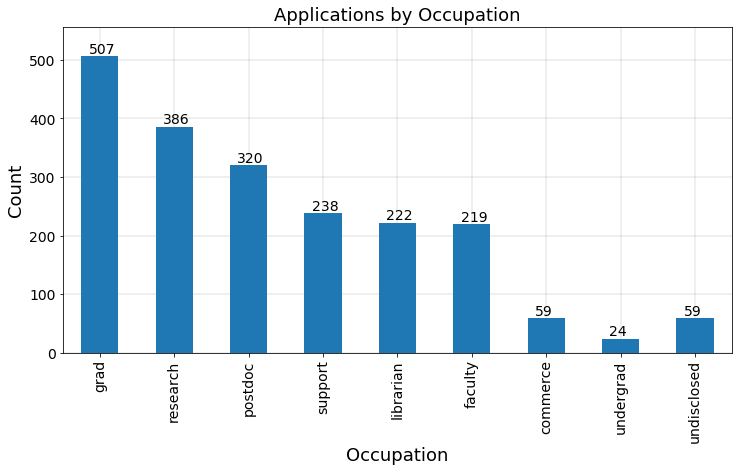

In [21]:
apps_by_occupation = all_applications['Occupation'].value_counts().to_frame()

apps_by_occupation.rename(columns={'Occupation':"Count", True:"online"}, inplace=True)

apps_by_occupation.index.name = 'Occupation'

fig = plt.figure(figsize=(12, 6)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
width = .5 # Set width of bar

without_other = apps_by_occupation.drop("undisclosed", axis=0).sort_values('Count', ascending=False)
just_other = apps_by_occupation.loc[['undisclosed']]

apps_by_occupation = pd.concat([without_other, just_other])

title = "Applications by Occupation"
apps_by_occupation.plot(kind='bar', ax=ax, title=title, legend=False, grid=True,)

# # Set axes labels and legend
ax.set_xlabel("Occupation")
ax.set_ylabel("Count")

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)   

ax.title.set_size(18)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14, rotation=0)


ax.grid(linestyle='-', linewidth='0.25', color='gray')

for i, label in enumerate(list(apps_by_occupation.index)):
    count = apps_by_occupation.loc[label]['Count']
    ax.annotate(str(count), (i - 0.15, count + 5), fontsize=14)

ax.set_ylim(0, max(apps_by_occupation['Count']) + 50)   
    
plt.show()


## Figure 9: Instructor Training Events

Numbers for {{ current_year }} represent actual data through {{ report_month }} {{ report_year }}.  Source data can be found in Table 8 of the Appendix.

In [22]:
instructor_training = pd.read_csv("../data_files/instructor_training_events.csv", keep_default_na=False, na_values=[''])

# Remove events before report date
# Remove the ones that are tagged 6 only
# There are other events like trainer training and onboardings
instructor_training = instructor_training[instructor_training['tags'] != '6']

instructor_training['start'] = pd.to_datetime(instructor_training['start'])

instructor_training = instructor_training[instructor_training['start'] < report_date]

instructor_training.loc[:, 'online'] =  (instructor_training.loc[:, 'country'] == "W3")
instructor_training['count_badged'].fillna(0, inplace=True)
instructor_training['count_badged'] = instructor_training['count_badged'].astype(int)
instructor_training['pct_badged'] = instructor_training['count_badged']/instructor_training['attendance']*100
instructor_training['pct_badged'] = instructor_training['pct_badged'].round(0)
instructor_training['pct_badged'] = instructor_training['pct_badged'].astype(int)


In [23]:
checkout_time  = pd.Timedelta(3, "M")
report_date_3mos_before = report_date - checkout_time

instructor_training_exclude_last3mos = instructor_training[instructor_training['start'] <= report_date_3mos_before]


In [24]:
instructor_training_by_year = instructor_training.groupby([instructor_training['start'].dt.year, 'online'])['slug'].count().unstack()
instructor_training_by_year.rename(columns={False:"in-person", True:"online"}, inplace=True)
instructor_training_by_year.index.names = ['Year']
instructor_training_by_year.columns.names = ["Type"]
instructor_training_by_year.fillna(0, inplace=True)
instructor_training_by_year = instructor_training_by_year.astype(int)

# df.rename(index=str, columns={"A": "a", "B": "c"})

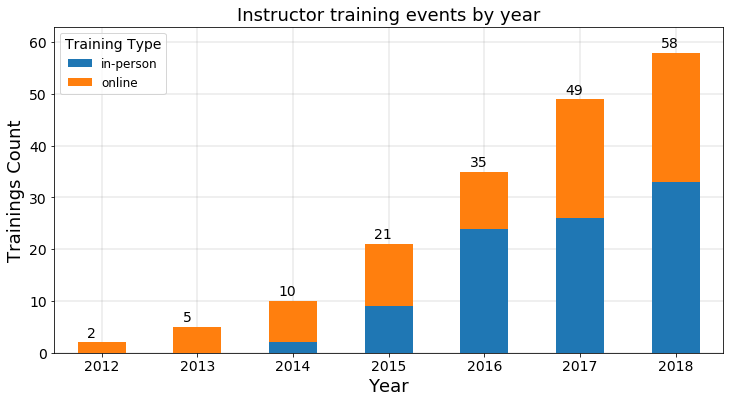

In [25]:
fig = plt.figure(figsize=(12, 6)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes

width = .5 # Set width of bar
title = "Instructor training events by year"

# Plot chart
instructor_training_by_year.plot(y = ["in-person", "online"], kind='bar', ax=ax, width=width,  title=title, stacked=True,)

# Set axes labels and legend
ax.set_xlabel("Year")
ax.set_ylabel("Trainings Count")
# ax.legend(title="Workshop Type", fontsize=12)
leg = ax.legend(fontsize=12)
leg.set_title(title="Training Type", prop={'size':14,})
ax.title.set_size(18)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)

# Customize the gridlines
ax.grid(linestyle='-', linewidth='0.25', color='gray')

# # Create a new dataframe that has just the total number of workshops by year
totals = instructor_training_by_year['in-person'] + instructor_training_by_year['online']
years = list(totals.index)


# # Figure out what the xmarks values are (xtick values; they are not year like you'd think)
# # Add them to an empty list
# # The list will be double what's expected as it goes through all the stacked values
xmarks = []
for p in ax.patches:
#     print("X: ", p.get_x())
#     print("Y: ", p.get_height())
    xmarks.append(p.get_x())


# # Make an empty list to be populated with a tuple for each stack
# # Go through the length of the totals series
# # Add to the empty list a tuple: (position in totals df, position in xmarks list)
t = []

for y in range(len(totals)):
    t.append((list(totals)[y], xmarks[y]))


# # Annotate the stacked bar chart with 
# # (annotation text, position of text)
for p in t:
    ax.annotate(str(p[0]), (p[1] + .1, p[0] + 1), fontsize=14)

# # Don't allow the axis to be on top of your data
ax.set_axisbelow(True)    

ax.set_ylim(0,max(totals) + 5)

    
# Display the plot   
plt.show()

# See
# https://stackoverflow.com/questions/40783669/stacked-bar-plot-by-group-count-on-pandas-python


## Figure 10: Badging Rates at online vs. in-person events

This chart shows the average of the percent badged each year.  Source data can be found in Table 9 of the Appendix.

In [26]:
avg_badged_by_year = instructor_training_exclude_last3mos.groupby([instructor_training_exclude_last3mos['start'].dt.year, 'online'])['pct_badged'].mean().unstack()

avg_badged_by_year.rename(columns={False:"in-person", True:"online"}, inplace=True)
avg_badged_by_year.index.names = ['Year']
avg_badged_by_year.columns.names = ["Percent Badged"]
avg_badged_by_year.fillna(0, inplace=True)

avg_badged_by_year = avg_badged_by_year.round()
avg_badged_by_year = avg_badged_by_year.astype(int)


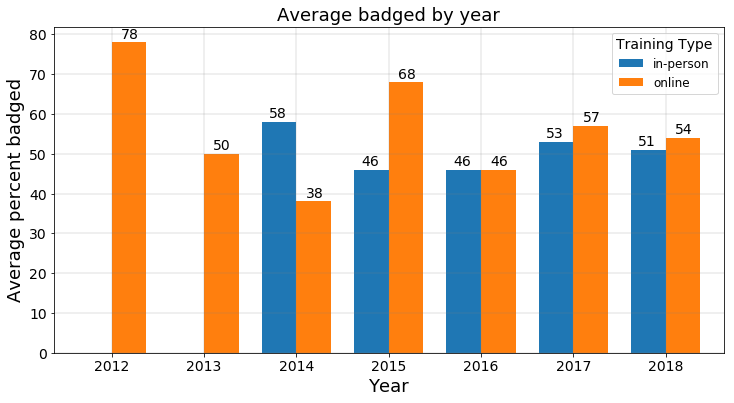

In [27]:
fig = plt.figure(figsize=(12, 6)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes

width = .75 # Set width of bar
title = "Average badged by year"

# Plot chart
avg_badged_by_year.plot(y = ["in-person", "online"], kind='bar', ax=ax, width=width,  title=title, stacked=False,)

# Set axes labels and legend
ax.set_xlabel("Year")
ax.set_ylabel("Average percent badged")
# ax.legend(title="Workshop Type", fontsize=12)
leg = ax.legend(fontsize=12)
leg.set_title(title="Training Type", prop={'size':14,})
ax.title.set_size(18)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)

# Customize the gridlines
ax.grid(linestyle='-', linewidth='0.25', color='gray')


for i, label in enumerate(list(avg_badged_by_year.index)):
    count = avg_badged_by_year.loc[label]['in-person']
    if count > 0:
        ax.annotate(str(count), (i-.3, count + 1), fontsize=14)

# ax.set_ylim(0, max(apps_by_expertise_areas['Count']) + 5)   
    

for i, label in enumerate(list(avg_badged_by_year.index)):
    count = avg_badged_by_year.loc[label]['online']
    if count > 0:
        ax.annotate(str(count), (i + .1, count + 1 ), fontsize=14)

plt.show()

In [28]:
all_instructors = pd.read_csv("../data_files/cumulative_instructors.csv", keep_default_na=False, na_values=[''])
total_badged_instructors = all_instructors['count'].max()

## Figure 11: Badged Instructors

Cumulative count by year of all instructors badged through {{ report_month }} {{ report_year }}.  As of {{ report_month }} {{ report_year }}, The Carpentries had a total of {{ total_badged_instructors }} instructors.

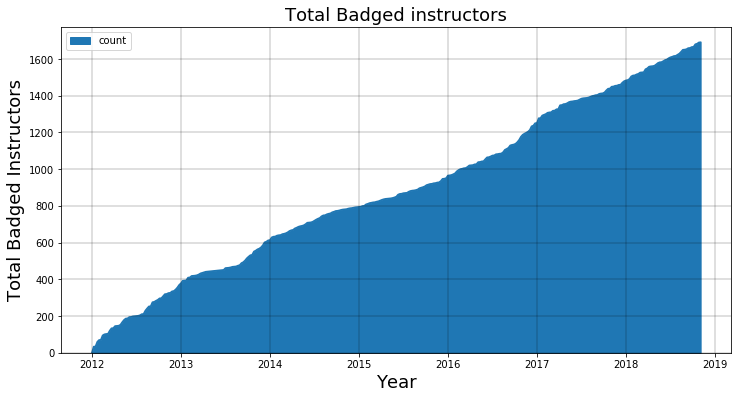

In [29]:
fig = plt.figure(figsize=(12, 6)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes


# fig, ax = plt.subplots()
title = "Total Badged instructors"

# Plot chart
all_instructors.plot(kind='area', x="date", y='count', ax=ax, title=title)

# # Set axes labels and legend
ax.set_xlabel("Year")
ax.set_ylabel("Total Badged Instructors")
# # ax.legend(title="Workshop Type", fontsize=12)
# leg = ax.legend(fontsize=12)
# leg.set_title(title="Training Type", prop={'size':14,})
ax.title.set_size(18)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
# plt.xticks(fontsize=14, rotation=0)
# plt.yticks(fontsize=14, rotation=0)

xticks = ["", 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
ax.set_xticklabels(xticks)

# Customize the gridlines
ax.grid(linestyle='-', linewidth='0.25', color='black')

# # Don't allow the axis to be on top of your data
ax.set_axisbelow(False)    

plt.show()

# Part 4: Teaching

## Figure 12: Teaching Frequency

Source data can be found in Table 10 of the Appendix.

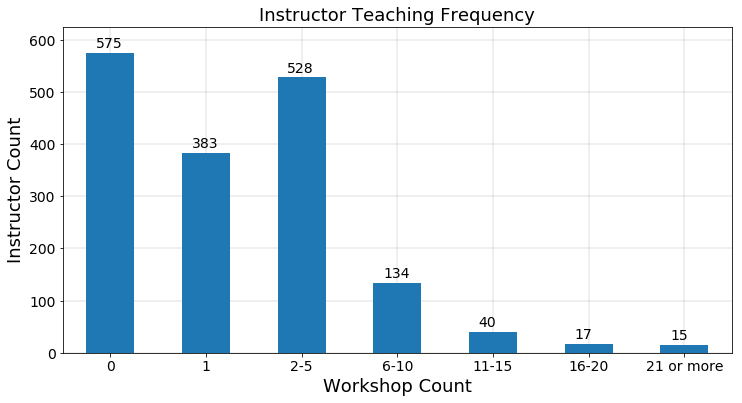

In [30]:
teaching_frequency = pd.read_csv("../data_files/teaching_frequency.csv")

# https://stackoverflow.com/questions/44314670/create-rename-categories-with-pandas
# df['new'] = pd.cut(df.age, 
#                    bins=[0, 19, 29, 39, 49, 59, 999], 
#                    labels=['0-19', '20-29', '30-39', '40-49', '50-59', '60+'],
#                    include_lowest=True)

xticks = ['0', '1', '2-5', '6-10', '11-15', '16-20', '21 or more']

bins = pd.cut(teaching_frequency['num_taught'], 
              bins = [-1, 0, 1, 5, 10, 15, 20, np.inf],
              labels = xticks)

num_workshops_taught_binned = teaching_frequency.groupby(bins)['num_taught'].agg(['count'])

num_workshops_taught_binned = num_workshops_taught_binned.unstack().to_frame()



num_workshops_taught_binned.rename(columns={0:'count'}, inplace=True)

num_workshops_taught_binned.index.names = ["", 'workshops taught']

fig = plt.figure(figsize=(12, 6)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)   

title = "Instructor Teaching Frequency"

num_workshops_taught_binned.plot(kind='bar', ax=ax, title=title, legend=False, grid=True)
ax.set_ylabel("Instructor Count")
ax.set_xlabel("Workshop Count")
ax.set_xticklabels(xticks)

ax.title.set_size(18)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)


ax.grid(linestyle='-', linewidth='0.25', color='gray')


for i, label in enumerate(list(num_workshops_taught_binned.index)):
    count = num_workshops_taught_binned.loc[label]['count']
    ax.annotate(str(count), (i - 0.15, count + 10), fontsize=14)

ax.set_ylim(0, max(num_workshops_taught_binned['count']) + 50)   

plt.show()

# Part 5: Trainers

## Overview

Until 2016, all Instructor Training events were run as online events by the Software Carpentry founder and former Executive Director. Knowing the limitations of having only one Instructor Trainer, in 2016, The Carpentries launched a training program for Instructor Trainers (https://carpentries.github.io/trainer-training/).  

This allowed us to expand reach by running several events a month, across timezones for online events. It also allowed us to build capacity at member organizations who have onsite Instructor Trainers. These Trainers run events for their site building a community of trained and certified instructors there. 

By brining on new Trainers in Europe and more recently in Africa, we have a large community of Trainers who overlap time zones and connect with a wider audience. We've also expanded our geographic reach, allowing us to reach communities we may not otherwise connect with.


In [31]:
trainers = pd.read_csv("../data_files/trainers.csv", keep_default_na=False, na_values=[''])

trainers.rename(columns={"country": "country2",}, inplace=True)

# Apply the function to get the full country name
trainers['country'] = trainers['country2'].apply(get_country_name)
trainers['country3'] = trainers['country2'].apply(get_country_code3)

trainers['awarded'] = pd.to_datetime(trainers['awarded'])
# trainers['country'] = trainers['country'].apply(get_country_name)
trainers['year'] = trainers['awarded'].dt.year

## Figure 13: New Trainers by Year

As of {{ report_month }} {{ report_year }}, The Carpentries has {{len(trainers)}} Instructor Trainers on board.
Source data can be found in Table 11 of the Appendix.

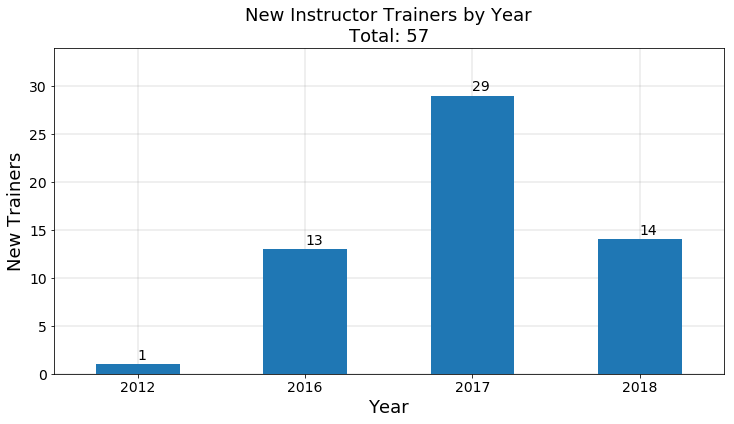

In [32]:
fig = plt.figure(figsize=(12, 6)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
width = .5 # Set width of bar

trainers_by_year = trainers.groupby(trainers['year']).awarded.count().to_frame()
trainers_by_year.rename(columns={'id':'count'}, inplace=True)
title = "New Instructor Trainers by Year" + "\n" + "Total: " +  str(len(trainers))
trainers_by_year.plot(kind='bar', ax=ax, title=title, legend=False, grid=True,)

# Set axes labels and legend
ax.set_xlabel("Year")
ax.set_ylabel("New Trainers")
# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)   

ax.title.set_size(18)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)

trainers_by_year.rename(columns={'awarded':'count'}, inplace=True)

ax.grid(linestyle='-', linewidth='0.25', color='gray')

for i, label in enumerate(list(trainers_by_year.index)):
    count = trainers_by_year.loc[label]['count']
    ax.annotate(str(count), (i, count + 0.5), fontsize=14)

ax.set_ylim(0, max(trainers_by_year['count']) + 5)   
    
plt.show()

## Figure 14: Trainers by Country

Source data can be found in Table 12 of the Appendix.

In [33]:
trainers_by_country = trainers.groupby(['country', 'country3']).awarded.count().to_frame()
trainers_by_country.fillna(0, inplace=True)
trainers_by_country = trainers_by_country.astype(int)
trainers_by_country.rename(columns={'awarded':'count'}, inplace=True)
trainers_by_country.reset_index(inplace=True)

In [34]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).to_crs('+proj=robin') # world map

In [35]:
trainers_map = world.merge(trainers_by_country, left_on='iso_a3', right_on='country3')

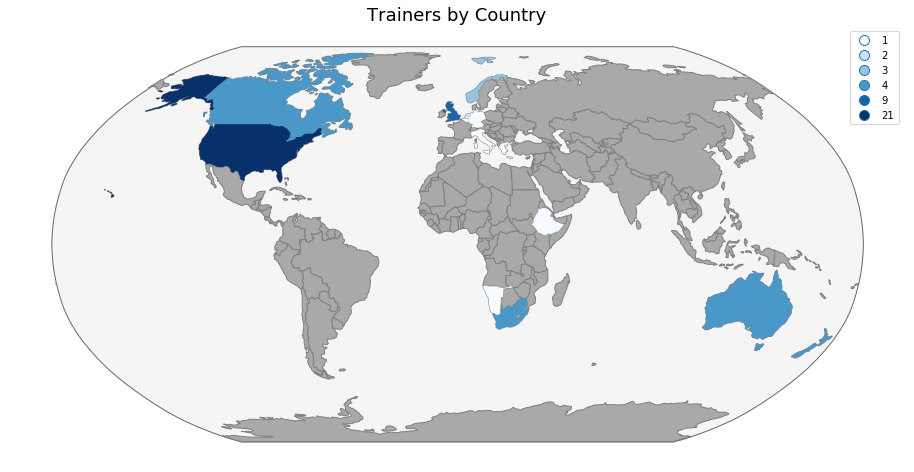

In [36]:
# Fill NAs with Zero so map can read
trainers_map.fillna(0, inplace=True)

# Drop the zero values so they are not in the legend or color scale
trainers_map = trainers_map[(trainers_map['count'] != 0)]

# Years as ints, not floats
trainers_map['count'] = trainers_map['count'].astype(int) 

# Drop the zero values so they are not in the legend or color scale
# first_wkshp_map = first_wkshp_map[(first_wkshp_map.year != 0)]

# #  Create map canvas
fig, ax = plt.subplots(figsize=(16,8))
# ax.axis('off')
bbox_robinson.plot(ax=ax, alpha=1, color='whitesmoke', edgecolor='dimgray')

# facecolor will not work if ax.axis is off
# ax.patch.set_facecolor('whitesmoke')

title = "Trainers by Country"
ax.set_title(title)
ax.get_figure().suptitle("")
ax.title.set_size(18)


# # # Plot basemap all in gray
world_robinson.plot(ax=ax, color='darkgrey', edgecolor='gray')
trainers_map.plot(ax=ax, column='count', categorical=True, cmap="Blues", legend=True,)

# # Drop x & y axis ticks
plt.xticks([], [])
plt.yticks([], [])


# Make the axes invisible by making them the same color as the background
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')

plt.show()


# Appendix

## Table 1: Workshops by Carpentry lesson program by Year


In [37]:
display(add_totals(workshops_by_carpentry_year))

Workshop Type,DC,SWC,row total
Year,,,
2012,0,38,38
2013,0,92,92
2014,2,137,139
2015,31,243,274
2016,72,273,345
2017,81,256,337
2018,121,294,415
column total,307,1333,1640


## Table 2: Workshops by Country by Year

In [38]:
display(add_totals(workshops_by_country_year))

Year,2012,2013,2014,2015,2016,2017,2018,row total
Country,,,,,,,,
Antarctica,0,0,0,0,0,0,1,1
Australia,0,6,10,32,41,33,29,151
Belgium,0,0,0,1,0,1,2,4
Botswana,0,0,0,0,0,1,0,1
Brazil,0,0,6,5,5,0,1,17
Canada,8,11,22,25,41,29,22,158
China,0,1,0,0,0,0,0,1
Colombia,0,0,0,0,1,0,0,1
Cyprus,0,0,1,0,0,0,0,1


## Table 3: Attendance by Carpentry lesson program by Year

In [39]:
display(add_totals(learners_by_year))

Workshop Type,DC,SWC,row total
Year,,,
2012,0,1378,1378
2013,0,3179,3179
2014,59,4683,4742
2015,790,6965,7755
2016,1604,5529,7133
2017,1659,5677,7336
2018,1899,4743,6642
column total,6011,32154,38165


## Table 4: Instructor Training Applications by Previous Experience Teaching

In [40]:
apps_by_prev_experience = apps_by_prev_experience.append(apps_by_prev_experience.sum(axis=0).rename("column total"))
display(apps_by_prev_experience)



,Count
Previous Experience,
Primary instructor,998
A few hours,468
None,279
Teaching assistant,169
A workshop,71
Other,245
column total,2230


## Table 5: Instructor Training Applications by Previous Training in Teaching

In [41]:
apps_by_prev_training = apps_by_prev_training.append(apps_by_prev_training.sum(axis=0).rename("column total"))
display(apps_by_prev_training)

,Count
Previous Training,
None,917
A certification or short course,388
A workshop,371
A few hours,219
A full degree,117
Other,213
column total,2225


## Table 6: Instructor Training Applications by Areas of Expertise

Totals are not included as applicants can select more than one area of expertise.

In [42]:
display(apps_by_expertise_areas)

,Count
Expertise areas,
Chemistry,121
"Civil, mechanical, chemical, or nuclear engineering",110
Computer science/electrical engineering,652
Economics/business,117
Education,216
"Genetics, genomics, bioinformatics",598
High performance computing,387
Humanities,180
Library and information science,330


## Table 7: Instructor Training Applications by Occupation

In [43]:
apps_by_occupation = apps_by_occupation.append(apps_by_occupation.sum(axis=0).rename("column total"))
display(apps_by_occupation)

,Count
Occupation,
grad,507
research,386
postdoc,320
support,238
librarian,222
faculty,219
commerce,59
undergrad,24
undisclosed,59


## Table 8: Instructor Training Events by Year

In [44]:
display(add_totals(instructor_training_by_year))

Type,in-person,online,row total
Year,,,
2012,0,2,2
2013,0,5,5
2014,2,8,10
2015,9,12,21
2016,24,11,35
2017,26,23,49
2018,33,25,58
column total,94,86,180


## Table 9: Average Badged by Instructor Training Event Type by Year

In [45]:
display(avg_badged_by_year)

Percent Badged,in-person,online
Year,,
2012,0,78
2013,0,50
2014,58,38
2015,46,68
2016,46,46
2017,53,57
2018,51,54


## Table 10: Instructor Teaching Frequency

In [46]:
display(num_workshops_taught_binned)

count
      workshops taught       
count 0                 575  
      1                 383  
      2-5               528  
      6-10              134  
      11-15             40   
      16-20             17   
      21 or more        15

## Table 11: New Instructor Trainers by Year

In [47]:
trainers_by_year = trainers_by_year.append(trainers_by_year.sum(axis=0).rename("column total"))
display(trainers_by_year)

,count
year,
2012,1
2016,13
2017,29
2018,14
column total,57


## Table 12: Instructor Trainers by Country

In [48]:
trainers_by_country = trainers_by_country[['country', 'count']].set_index('country')
trainers_by_country = trainers_by_country.append(trainers_by_country.sum(axis=0).rename("column total"))

display(trainers_by_country)

,count
country,
Australia,4
Belgium,1
Canada,4
Ethiopia,1
Germany,1
Greece,1
Italy,1
Namibia,1
Netherlands,2
